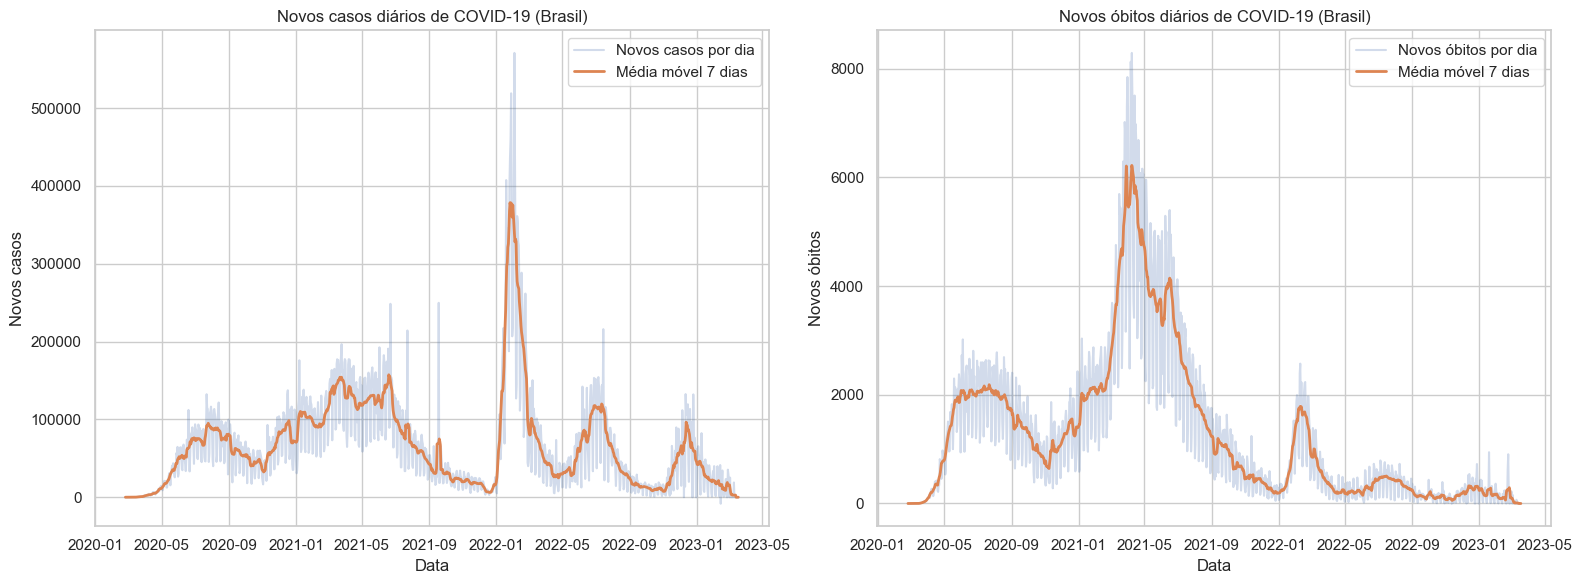

Data mais recente disponível: 2023-03-18


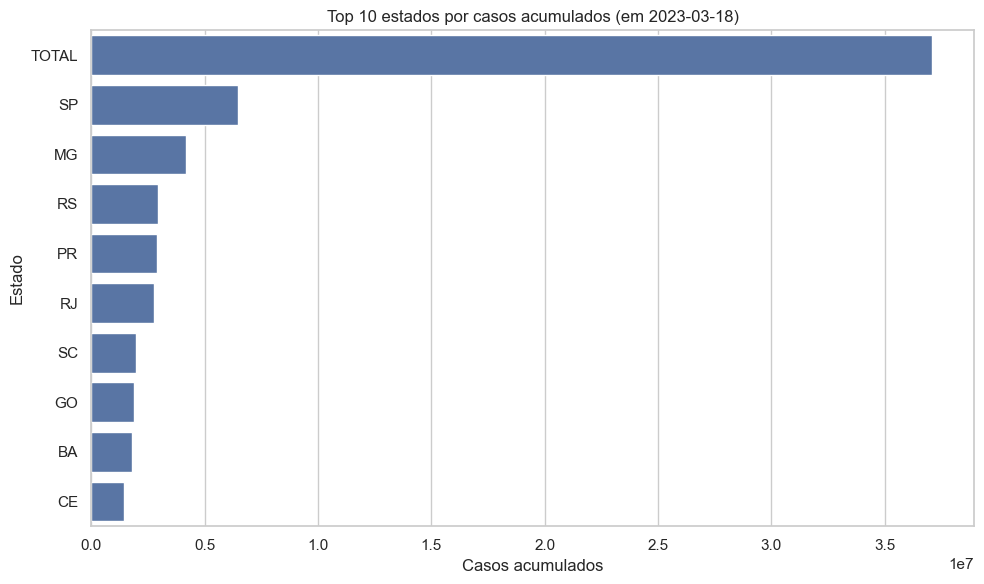

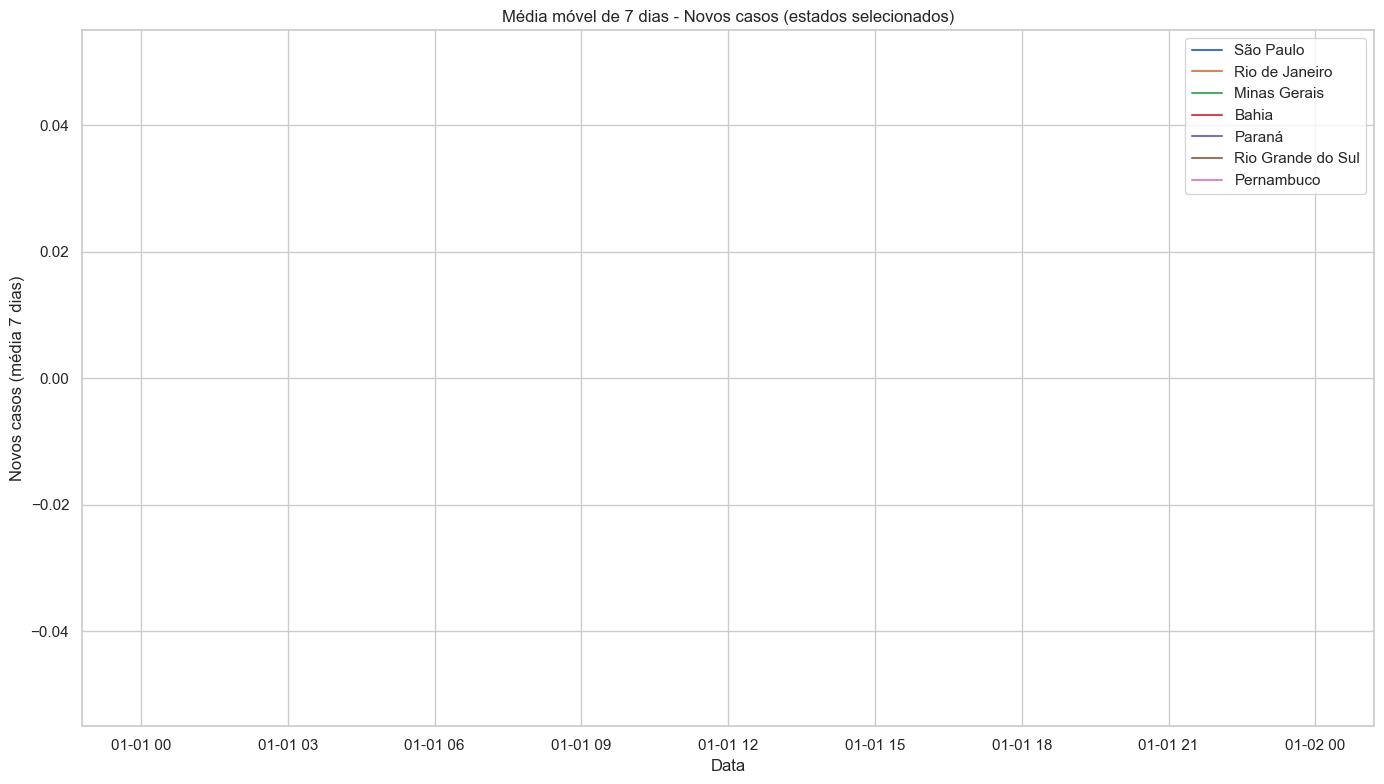

Eventos detectados:
- 2020-02-25 00:00:00: Primeiro caso confirmado no Brasil
- 2020-03-17 00:00:00: Primeiro óbito registrado
- 2021-01-17: Início da vacinação


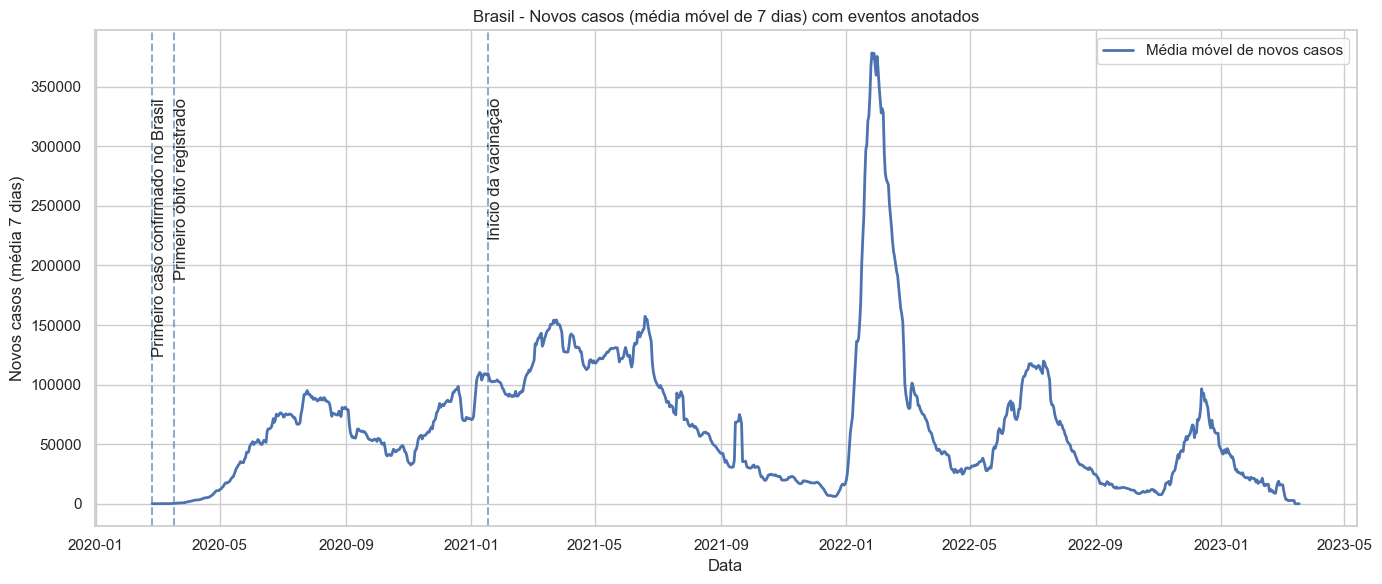


Estatísticas descritivas (Brasil):
            count          mean           std     min      25%      50%  \
newCases   1118.0  66342.611807  66717.081196 -8348.0  19865.0  49331.0   
newDeaths  1118.0   1251.001789   1442.486222    -4.0    226.5    696.0   

               75%       max  
newCases   93103.0  570792.0  
newDeaths   1859.0    8292.0  


In [ ]:
"""
Problema: (Precisa melhorar isso)

A pandemia de COVID-19 trouxe grandes impactos ao Brasil, exigindo o acompanhamento
detalhado da evolução de casos e óbitos ao longo do tempo. A análise exploratória de dados
é essencial para entender padrões, identificar momentos críticos e apoiar a criação de um
linha do tempo que conecte os dados a eventos marcantes na linha do tempo.

Solução:

Este notebook implementa uma análise exploratória e storytelling:
- Baixa os dados do repositório wcota/covid19br diretamente do GitHub.
- Faz uma limpeza e preparação dos dados.
- Calcula estatísticas descritivas e médias móveis (7 dias) não funcinou mt bem a média móvel.
- Gera gráficos de séries temporais nacionais e por estado, comparando casos e óbitos.
- Cria visualizações com eventos (primeiro caso, primeiro óbito, início da vacinação).
- Exibe os gráficos.

"""


import os
import io
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')


URL = (
    "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv"
)
OUTPUT_DIR = "outputs_covid19br"
STATE_SELECTION = ["São Paulo", "Rio de Janeiro", "Minas Gerais", "Bahia", "Paraná", "Rio Grande do Sul", "Pernambuco"]

os.makedirs(OUTPUT_DIR, exist_ok=True)
resp = requests.get(URL)
resp.raise_for_status()

dados = pd.read_csv(io.StringIO(resp.text), parse_dates=["date"])


#limpando os dados para melhor visualização
dados.columns = [c.strip() for c in dados.columns]

colunas_map = {
    'new_confirmed': 'newCases',
    'new_deaths': 'newDeaths',
    'totalCases': 'cases',
    'totalCasesMS': 'cases',
    'deaths': 'deaths',
    'deathsMS': 'deaths'
}

for old, new in colunas_map.items():
    if old in dados.columns and new not in dados.columns:
        dados.rename(columns={old: new}, inplace=True)


for col in ['cases', 'deaths', 'newCases', 'newDeaths']:
    if col not in dados.columns:
        dados[col] = 0


for col in ['cases','deaths','newCases','newDeaths']:
    dados[col] = pd.to_numeric(dados[col], errors='coerce').fillna(0).astype(int)


nacional = dados.groupby('date', as_index=False).agg({'newCases':'sum', 'newDeaths':'sum', 'cases':'sum', 'deaths':'sum'})
nacional = nacional.sort_values('date')

nacional['casos_media7d'] = nacional['newCases'].rolling(window=7, center=True, min_periods=1).mean()
nacional['obitos_media7d'] = nacional['newDeaths'].rolling(window=7, center=True, min_periods=1).mean()


fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)

# Casos
axes[0].plot(nacional['date'], nacional['newCases'], alpha=0.25, label='Novos casos por dia')
axes[0].plot(nacional['date'], nacional['casos_media7d'], linewidth=2, label='Média móvel 7 dias')
axes[0].set_title('Novos casos diários de COVID-19 (Brasil)')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Novos casos')
axes[0].legend()

# Óbitos
axes[1].plot(nacional['date'], nacional['newDeaths'], alpha=0.25, label='Novos óbitos por dia')
axes[1].plot(nacional['date'], nacional['obitos_media7d'], linewidth=2, label='Média móvel 7 dias')
axes[1].set_title('Novos óbitos diários de COVID-19 (Brasil)')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Novos óbitos')
axes[1].legend()

plt.tight_layout()
plt.show()


data_mais_recente = dados['date'].max()
print('Data mais recente disponível:', data_mais_recente.date())

estados_mais_recente = dados[dados['date']==data_mais_recente].sort_values('cases', ascending=False)


import seaborn as sns
top10 = estados_mais_recente[['state','cases']].nlargest(10, 'cases')
plt.figure(figsize=(10,6))
sns.barplot(data=top10, y='state', x='cases')
plt.title(f'Top 10 estados por casos acumulados (em {data_mais_recente.date()})')
plt.xlabel('Casos acumulados')
plt.ylabel('Estado')
plt.tight_layout()
plt.show()


sel = dados[dados['state'].isin(STATE_SELECTION)].copy()
sel = sel.sort_values(['state','date'])
sel['newCases_7d'] = sel.groupby('state')['newCases'].transform(lambda x: x.rolling(7, center=True, min_periods=1).mean())

plt.figure(figsize=(14,8))
for s in STATE_SELECTION:
    serie = sel[sel['state']==s]
    plt.plot(serie['date'], serie['newCases_7d'], label=s)

plt.title('Média móvel de 7 dias - Novos casos (estados selecionados)')
plt.xlabel('Data')
plt.ylabel('Novos casos (média 7 dias)')
plt.legend()
plt.tight_layout()
plt.show()




eventos = []


primeiro_caso = nacional.loc[nacional['newCases'] > 0, 'date'].min()
if pd.notna(primeiro_caso):
    eventos.append({"date": primeiro_caso, "label": "Primeiro caso confirmado no Brasil"})





primeiro_obito = nacional.loc[nacional['newDeaths'] > 0, 'date'].min()
if pd.notna(primeiro_obito):
    eventos.append({"date": primeiro_obito, "label": "Primeiro óbito registrado"})

#se alguém tiver essa data seria bom inseri aqui não tenho pelo dataset
eventos.append({"date": "xxxx-xxx-xxx-xx", "label": "Início da vacinação"})


print("Fatos Curiosos:")
for ev in eventos:
    print(f"- {ev['date']}: {ev['label']}")


plt.figure(figsize=(14,6))
plt.plot(nacional['date'], nacional['casos_media7d'], linewidth=2, label='Média móvel de novos casos')

for ev in eventos:
    ev_date = pd.to_datetime(ev['date'])
    plt.axvline(ev_date, linestyle='--', alpha=0.6)
    plt.text(ev_date, nacional['casos_media7d'].max()*0.9, ev['label'], rotation=90, va='top')

plt.title('Novos casos (média móvel de 7 dias) com eventos anotados')
plt.xlabel('Data')
plt.ylabel('Novos casos (média 7 dias)')
plt.legend()
plt.tight_layout()
plt.show()



desc = nacional[['newCases','newDeaths']].describe().transpose()
print("\nEstatísticas descritivas (Brasil):")
print(desc)
